## Winding layout procedure

In [ ]:
import numpy as np
import pandas as pd

slot = 15
pole = 14
phase = 3
R_ro = 0.025
R_so = 0.05
L_st = 0.03
g = 0.0005
Vmax = 60
Imax = 40
Wmax = Imax*Vmax
w_max = 4000*2*np.pi/60
Br = 1.46
Hc = 1059000
uR=Br/Hc
u0 = 1.2566e-16
Bg=0.5*Br
N=10
ds = 0.005
Tmax=Wmax/(w_max)
back_emf = Tmax*w_max*2*np.pi/60/Imax
lm = 0.001
wsb = 2*np.pi/15*R_so*0.3
pole =14
wso = wsb*0.3
dt = 0.002
dsh = 0.0008
N=10

#---------------------------------
coil_pitch = max(int(slot/pole),1)
print('coil_pitch:',coil_pitch)
theta_m = 360/slot
theta_e = pole/2*theta_m
S_ = max(int(slot/pole),1)
slot_in = np.arange(1,slot+1)
slot_out = np.concatenate((slot_in[S_:],slot_in[:S_]))


coil_pitch: 1


In [223]:
def swap(a,b):
    return b,a
angle = np.arange(slot)*theta_e
# turn angle to -180~180
angle180 = np.array([])
for i in angle:
    if i > 180:
        i%=360
    if i>180:
        i = i-360
    angle180 = np.append(angle180,i)
print(angle180)
# turn angle to -90~90
angle90 = np.array([])
for i in range(len(angle180)):
    if angle180[i] > 90:
        angle180[i] = angle180[i]-180
        slot_in[i],slot_out[i] = swap(slot_in[i],slot_out[i])
    if angle180[i] < -90:
        angle180[i] = angle180[i]+180
        slot_in[i],slot_out[i] = swap(slot_in[i],slot_out[i])
    angle90 = np.append(angle90,angle180[i])
print(angle90)
# find the angle is close to 0 is phase A
# find the angle is close to 120(-60) is phase B
# find the angle is close to 240(-120) is phase C
phaseA = np.array([])
phaseB = np.array([])
phaseC = np.array([])
for i in range(len(angle90)):
    ## phase A
    if -30<=angle90[i]<30:
        phaseA = np.append(phaseA,i)
    ## phase B
    elif -90<=angle90[i]<-30:
        phaseB = np.append(phaseB,i)
        angle90[i] = angle90[i]+180
        slot_in[i],slot_out[i] = swap(slot_in[i],slot_out[i])
    elif angle90[i]==90:
        phaseB = np.append(phaseB,i)
    ## phase C
    elif 90>angle90[i]>=30:
        phaseC = np.append(phaseC,i)
        angle90[i] = angle90[i]+180
        slot_in[i],slot_out[i] = swap(slot_in[i],slot_out[i])

print('phaseA:',phaseA)
print('phaseB:',phaseB)
print('phaseC:',phaseC)
print('angle',angle90)


[   0.  168.  -24.  144.  -48.  120.  -72.   96.  -96.   72. -120.   48.
 -144.   24. -168.]
[  0. -12. -24. -36. -48. -60. -72. -84.  84.  72.  60.  48.  36.  24.
  12.]
phaseA: [ 0.  1.  2. 13. 14.]
phaseB: [3. 4. 5. 6. 7.]
phaseC: [ 8.  9. 10. 11. 12.]
angle [  0. -12. -24. 144. 132. 120. 108.  96. 264. 252. 240. 228. 216.  24.
  12.]


In [224]:
## create a dataframe to show the result
phase_a = np.zeros(slot)
phase_b = np.zeros(slot)
phase_c = np.zeros(slot)
for i in range(len(phaseA)):
    phase_a[int(phaseA[i])] = 1
    phase_b[int(phaseB[i])] = 1
    phase_c[int(phaseC[i])] = 1
#print('phase_a:',phase_a)
#print('phase_b:',phase_b)
#print('phase_c:',phase_c)
data = {'slot_in':slot_in,'slot_out':slot_out,'angle':angle90,'phase_a':phase_a,'phase_b':phase_b,'phase_c':phase_c}
df = pd.DataFrame(data)
## visualize the result
#TODO
df


,slot_in,slot_out,angle,phase_a,phase_b,phase_c
0,1,2,0.0,1.0,0.0,0.0
1,3,2,-12.0,1.0,0.0,0.0
2,3,4,-24.0,1.0,0.0,0.0
3,4,5,144.0,0.0,1.0,0.0
4,6,5,132.0,0.0,1.0,0.0
5,6,7,120.0,0.0,1.0,0.0
6,8,7,108.0,0.0,1.0,0.0
7,8,9,96.0,0.0,1.0,0.0
8,9,10,264.0,0.0,0.0,1.0
9,11,10,252.0,0.0,0.0,1.0


In [225]:
# create IO table
slot_num = np.arange(1,slot+1)
#print('slot_in',slot_in)
#print('slot_out',slot_out)
#print('phase_a:',phase_a)
#print('phase_b:',phase_b)
#print('phase_c:',phase_c)
phase_A = np.zeros(slot)
phase_B = np.zeros(slot)
phase_C = np.zeros(slot)
## 1->IN, -1->OUT, 0->NULL, 2->IN&IN, -2->OUT&OUT
IO_table = pd.DataFrame({'A':phase_A,'B':phase_B,'C':phase_C})
IO_table.index+=1
for i in range(slot):
    if phase_a[i] == 1:
        IN = slot_in[i]
        OUT = slot_out[i]
        IO_table.loc[IN,'A'] += 1
        IO_table.loc[OUT,'A'] -= 1
    if phase_b[i] == 1:
        IN = slot_in[i]
        OUT = slot_out[i]
        IO_table.loc[IN,'B'] += 1
        IO_table.loc[OUT,'B'] -= 1
    if phase_c[i] == 1:
        IN = slot_in[i]
        OUT = slot_out[i]
        IO_table.loc[IN,'C'] += 1
        IO_table.loc[OUT,'C'] -= 1
IO_table

,A,B,C
1,2.0,0.0,0.0
2,-2.0,0.0,0.0
3,2.0,0.0,0.0
4,-1.0,1.0,0.0
5,0.0,-2.0,0.0
6,0.0,2.0,0.0
7,0.0,-2.0,0.0
8,0.0,2.0,0.0
9,0.0,-1.0,1.0
10,0.0,0.0,-2.0


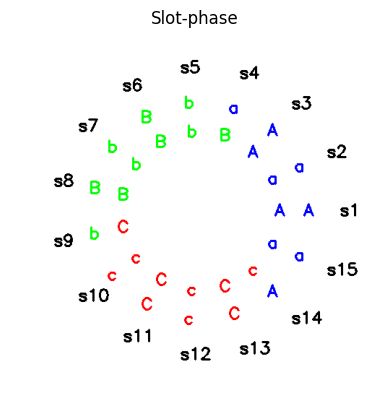

In [226]:
## to be visualized
import matplotlib.pyplot as plt
import cv2
img = np.ones((512,512,3), np.uint8)*255 ## create a white image
center = (img.shape[0]//2,img.shape[1]//2)
color = {'A':(0,0,255),'B':(0,255,0),'C':(255,0,0)}

def polar_draw(r,theta,text,center,c):
    x = int(r*np.cos(theta)+center[0])
    y = int(r*np.sin(theta)+center[1])
    #cv2.line(img,center,(x,y),(255,0,0),2)
    cv2.putText(img,text,(x,y),cv2.FONT_HERSHEY_SIMPLEX,0.75,c,2)
    return x,y
## draw the slot
angle = 360/slot
for i in range(slot):
    r = 200
    theta = (360 - angle*i)*np.pi/180#-angle//2*np.pi/180
    x,y = polar_draw(r,theta,"s"+str(i+1),center,(0,0,0))
## draw the phase
r = 150
p = ['A','B','C']
for i in range(1,len(df)+1):
    shift = 0
    c = 0 
    for j in p:
        if IO_table.loc[i,j] == 1:
            theta = (360 - angle*(i-1))*np.pi/180
            x,y = polar_draw(r-40*c,theta,str(j),center,color[j])
            c+=1
        if IO_table.loc[i,j] == 2:
            theta = (360 - angle*(i-1))*np.pi/180
            x,y = polar_draw(r,theta,str(j),center,color[j])
            x,y = polar_draw(r-40,theta,str(j),center,color[j])

        if IO_table.loc[i,j] == -1:
            theta = (360 - angle*(i-1))*np.pi/180
            x,y = polar_draw(r-40*c,theta,str(j.lower()),center,color[j])
            c+=1
        if IO_table.loc[i,j] == -2:
            theta = (360 - angle*(i-1))*np.pi/180
            x,y = polar_draw(r,theta,str(j.lower()),center,color[j])
            x,y = polar_draw(r-40,theta,str(j.lower()),center,color[j])
        
        
plt.title('Slot-phase')
plt.axis('off')
plt.imshow(img)

In [227]:
def coil_phase(nuten, pole):
    if nuten % 3 != 0 or nuten < 3:
        return "槽數必須是3的倍數!"  # 槽數必須是3的倍數

    if pole % 2 != 0 or pole < 2:
        return "極數必須是偶數!"  # 極數必須是偶數

    if pole == nuten:
        return "極數不能等於槽數!"  # 極數不能等於槽數

    winkel = 180 * pole / nuten
    summe = 0
    schema = ""
    summe_l = []
    # 繞組分配
    for i in range(nuten):
        # A 最接近 0° 或 360°
        # B 最接近 120°
        # C 最接近 240°
        if summe >= 330 or summe < 30:
            schema += "A"
            summe_l.append(summe)
        elif summe >= 90 and summe < 150:
            schema += "B"
            summe_l.append(summe)
        elif summe >= 210 and summe < 270:
            schema += "C"
            summe_l.append(summe)
        
        elif summe >= 150 and summe < 210:
            schema += "a"
            summe_l.append(summe-180)
        elif summe >= 270 and summe < 330:
            schema += "b"
            summe_l.append(summe-180)
        elif summe >= 30 and summe < 90:
            schema += "c"
            summe_l.append(summe-180)
        summe = (summe + winkel) % 360
    #print(summe_l)

    # 驗證繞組平衡性
    a_count = schema.count("a")
    b_count = schema.count("b")
    c_count = schema.count("c")
    A_count = schema.count("A")
    B_count = schema.count("B")
    C_count = schema.count("C")

    if a_count == b_count == c_count and A_count == B_count == C_count:
        return schema
    else:
        return f"不平衡! ({schema})"

AaABbBbBCcCcCAa


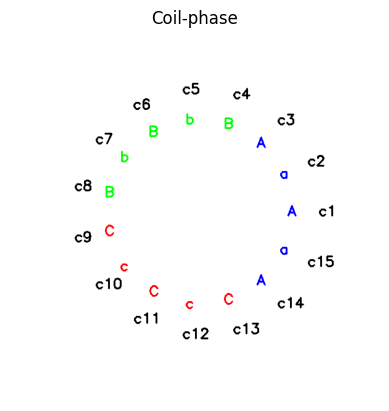

In [228]:
## visualize the coil phase
coil_phase_ = coil_phase(slot,pole)
print(coil_phase_)
img = np.ones((600,600,3), np.uint8)*255 ## create a white image
center = (img.shape[0]//2,img.shape[1]//2)
color = {'A':(0,0,255),'B':(0,255,0),'C':(255,0,0),'a':(0,0,255),'b':(0,255,0),'c':(255,0,0)}
angle = 360/slot
for i in range(slot):
    polar_draw(200,(360 - angle*i)*np.pi/180,"c"+str(i+1),center,(0,0,0))
for i in range(slot):
    r = 150
    theta = (360 - angle*i)*np.pi/180
    x,y = polar_draw(r,theta,coil_phase_[i],center,color[coil_phase_[i]])
plt.title('Coil-phase')
plt.axis('off')
plt.imshow(img)

AaABbBbBCcCcCAa
[  0. -12. -24. 144. 132. 120. 108.  96. 264. 252. 240. 228. 216.  24.
  12.]


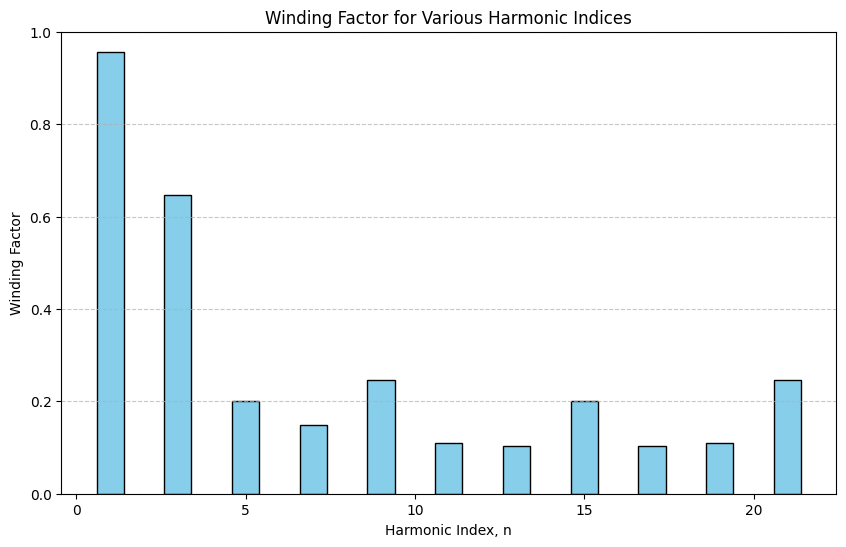

In [229]:
## plot the winding factor 
# done
import matplotlib.pyplot as plt
N_cph = slot//3
result = coil_phase(slot, pole)
print(result)
K_wn_list = []
angle = angle90
print(angle)
for n in range(11):
    K_wn = 0 
    for k in range(N_cph):
        if result[k] == 'A' or result[k]=='a':
            theta_k = angle[k]
        elif result[k] == 'B' or result[k]=='b':
            theta_k =  angle[k] -120
        elif result[k] == 'C' or result[k]=='c':
            theta_k =  angle[k] -240
            
        K_wn += np.cos(np.deg2rad((2*n+1)*theta_k))
    K_wn_list.append(abs(K_wn/N_cph))


plt.figure(figsize=(10, 6))
plt.bar(range(1,22,2),K_wn_list, color='skyblue', edgecolor='black')
plt.xlabel('Harmonic Index, n')
plt.ylabel('Winding Factor')
plt.title('Winding Factor for Various Harmonic Indices')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## back emf

theta_s: [np.float64(0.0), np.float64(-12.0), np.float64(-24.0), np.float64(24.0), np.float64(12.0)]
big: 168.0
small: 12.0


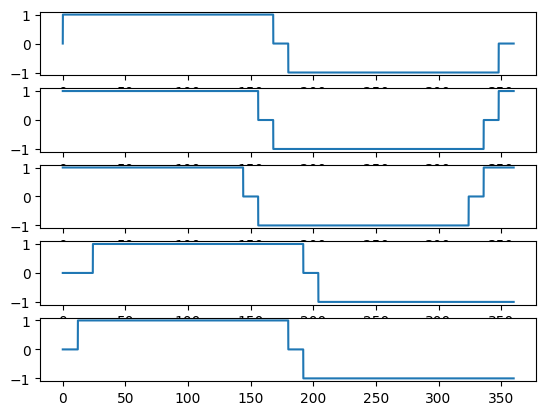

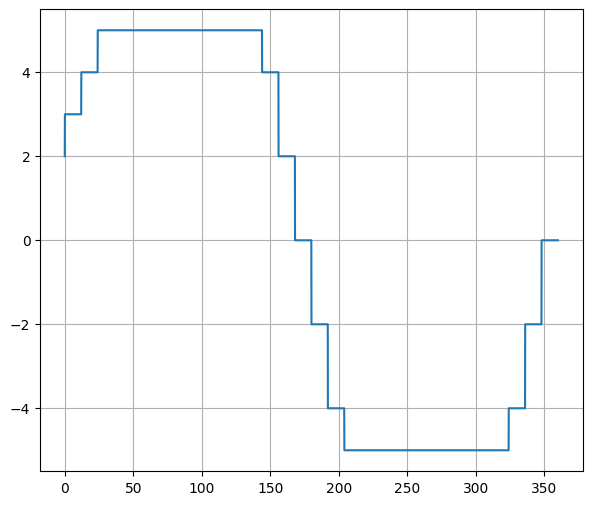

In [230]:
import numpy as np
import matplotlib.pyplot as plt
N_ = 10000
def heaviside(x, start_time):
    """Heaviside 函數"""
    return np.heaviside(x - start_time, 0)

def get_back_emf(slot, pole, df, simulate_max_angle=360):
    """生成 Back-EMF 波形的函數"""
    theta_m = 360 / slot  # 機械角
    theta_e = (pole / 2) * theta_m  # 電角
    coil_span = max(int(slot / pole), 1)  # 跨槽數
    coil_angle = 360 / slot  # 每槽角度
    coil_pitch = coil_span * coil_angle  # 每匝角度

    # 取出 Phase A 的 slot_in 和 slot_out
    df_a = df[df['phase_a'] == 1]
    slot_in = np.array(df_a['slot_in'])
    slot_out = np.array(df_a['slot_out'])
    s = (slot_in + slot_out) / 2
    s -= (slot_in[0] + slot_out[0]) / 2  # 平移

    # 產生電角
    theta_s = s * theta_e
    theta_s = [theta % 180 for theta in theta_s]  # 限制在 0 到 180
    theta_s = [theta - 180 if theta > 90 else theta for theta in theta_s]

    # 定義大步與小步
    big = theta_e * coil_span
    small = 180 - big

    print('theta_s:', theta_s)
    print('big:', big)
    print('small:', small)
    x = np.linspace(0, simulate_max_angle, N_)  # 定義時間軸
    y_final = np.zeros_like(x) 
    #theta_s = [0]
    for i in theta_s:
        # 繪製 Back-EMF 波形
        y = np.zeros_like(x)  # 初始化波形
        aa = i
        c = 0
        while aa < simulate_max_angle:
            if c % 4 == 0 :y += heaviside(x, aa);aa += big
            elif c % 4 ==1:y -= heaviside(x, aa);aa += small
            elif c % 4 ==2:y -= heaviside(x, aa);aa += big
            elif c % 4 ==3:y += heaviside(x, aa);aa += small
            c += 1
        y_final += y
        plt.subplot(len(theta_s), 1, theta_s.index(i) + 1)
        plt.plot(x, y, label=f'Initial Angle: {i}°')
    plt.figure(figsize=(7, 6))
    plt.grid()
    plt.plot(x, y_final, label=f'Initial Angle: {i}°')
    return x, y_final
# 執行
x,y_final= get_back_emf(slot, pole, df,360)

第 1 頻率的正弦波振幅: 6.03
第 2 頻率的正弦波振幅: 0.01
第 3 頻率的正弦波振幅: 1.26
第 4 頻率的正弦波振幅: 0.03
第 5 頻率的正弦波振幅: 0.22
第 6 頻率的正弦波振幅: 0.04
第 7 頻率的正弦波振幅: 0.03
第 8 頻率的正弦波振幅: 0.04
第 9 頻率的正弦波振幅: 0.01
第 10 頻率的正弦波振幅: 0.05
第 11 頻率的正弦波振幅: 0.04
第 12 頻率的正弦波振幅: 0.05
第 13 頻率的正弦波振幅: 0.05
第 14 頻率的正弦波振幅: 0.04
第 15 頻率的正弦波振幅: 0.04
第 16 頻率的正弦波振幅: 0.04
第 17 頻率的正弦波振幅: 0.04
第 18 頻率的正弦波振幅: 0.03
第 19 頻率的正弦波振幅: 0.02
第 20 頻率的正弦波振幅: 0.02
第 21 頻率的正弦波振幅: 0.01


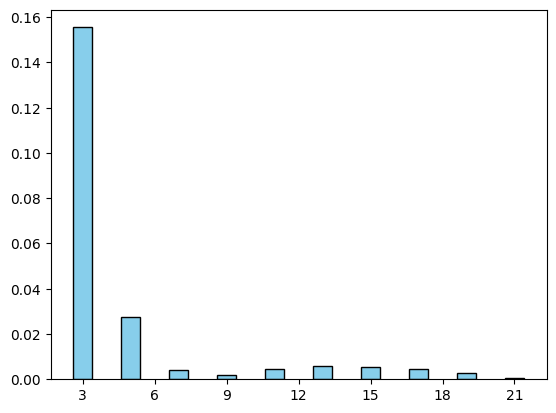

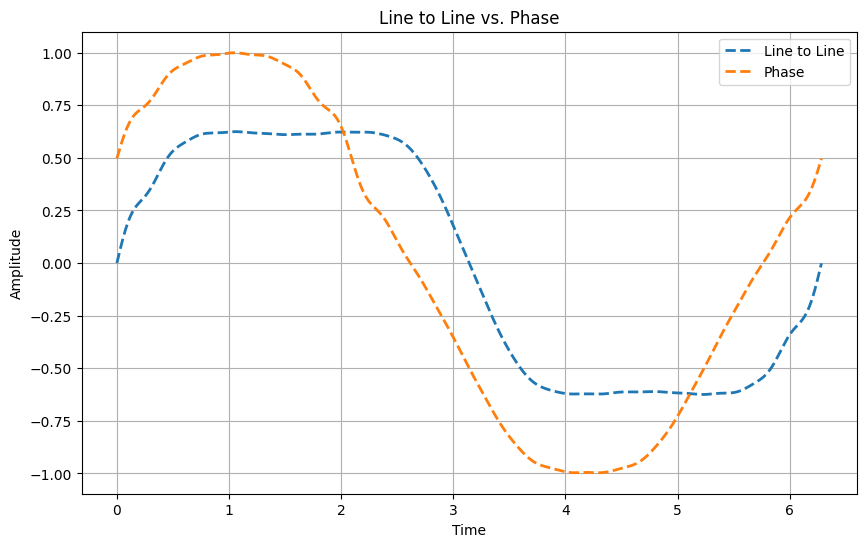

In [231]:
## fft 
# 取21項
from matplotlib.ticker import MaxNLocator
N_ = 10000
def fourier_sin(wave, k, N):
    t = np.linspace(0, 2 * np.pi, N, endpoint=False)  # 時間軸
    n_sin = np.sin(k * t)  # 第 k 頻率的正弦波
    s = np.sum(wave * n_sin) * (2 / N)  # 按 FFT 歸一化計算正弦項
    return abs(s)
t = np.linspace(0, 2 * np.pi, N_, endpoint=False)
n =21
ss = []
for i in range(1,n+1,1):
    s = fourier_sin(y_final, i, N_)
    ss.append(s)
    print(f'第 {i} 頻率的正弦波振幅: {s:.2f}')
#plt.bar(range(1,22,1),ss/sum(ss), color='skyblue', edgecolor='black')
ss = np.array(ss)
ss = ss/sum(ss)
plt.bar(range(3, 22, 2), ss[range(2, 21, 2)] / sum(ss), color='skyblue', edgecolor='black')
# 調整座標軸為整數
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # x 軸整數刻度
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))  # y 軸整數刻度


# 生成疊加的正弦波
y_reconstructed = np.zeros_like(t)  # 初始化疊加波
for i in range(1, n + 1):
    y_reconstructed += ss[i - 1] * np.sin(i * t)  # 根據振幅加權疊加
# 繪製原始波形與疊加波形
plt.figure(figsize=(10, 6))
#plt.plot(t, y_final, label='Original Wave', linewidth=2, alpha=0.7)
plt.plot(t, y_reconstructed, label='Reconstructed Wave', linestyle='--', linewidth=2)
#line to line
y_line2line = np.zeros_like(t)
y_line2line[:len(t)//3] = y_reconstructed[2*len(t)//3+1:]
y_line2line[len(t)//3+1:] = y_reconstructed[:2*len(t)//3]
plt.plot(t, (y_reconstructed-y_line2line)/max(y_reconstructed-y_line2line), label='Line to Line', linestyle='--', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Line to Line vs. Phase')
plt.legend(['Line to Line','Phase'])
plt.grid(True)
plt.show()

In [232]:
## Coil resistance
Resistance_coil = Vmax/Imax*0.95
print('Coil Resistance:',Resistance_coil)

## Air gap inductance
Lg = 2*np.pi*u0*L_st*R_ro*N*N/(g+lm/uR)

print('Lg:',Lg)
Ls = pole*(2*N)**2*((u0*ds*L_st/3/wsb)+(u0*dt*L_st/(wso+wsb)*2)+(u0*dsh*L_st/wso))
print('Ls:',Ls)
Lph = Lg+Ls
print('Lph:',Lph)

Coil Resistance: 1.4249999999999998
Lg: 8.163845618328371e-20
Ls: 2.4897727219249524e-14
Lph: 2.489780885770571e-14


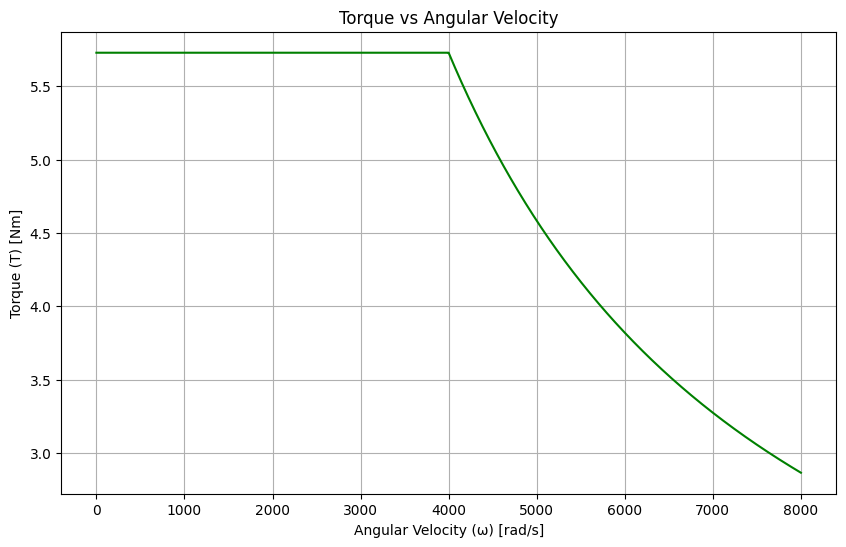

In [233]:
## T-N curve
# 定義參數
T_max = Tmax  # 最大轉矩
P_fixed = Wmax # 固定功率 (W)

# 定義角速度範圍
w1 = np.linspace(0, 4000, 500)  # 0 到 4000 的範圍，扭矩保持最大值
w2 = np.linspace(4000, 8000, 500)  # 超過 4000 的範圍，計算 T = P / w

# 計算 T
T1 = np.full_like(w1, T_max)  # 在 0 到 4000 範圍內保持最大轉矩
T2 = P_fixed / w2*60/2/np.pi # 超過 4000 的範圍，根據 T = P / w 計算

# 合併數據
w = np.concatenate((w1, w2))
T = np.concatenate((T1, T2))

# 繪製圖形
plt.figure(figsize=(10, 6))
plt.plot(w, T, label=f'Max Torque = {T_max} Nm (0-4000 rad/s), T = P/ω (4000+ rad/s)', color='green')

# 添加標籤和標題
plt.xlabel("Angular Velocity (ω) [rad/s]")
plt.ylabel("Torque (T) [Nm]")
plt.title("Torque vs Angular Velocity")
plt.grid(True)
plt.show()



## pitch factor & distribution factor 
## but for induction motor

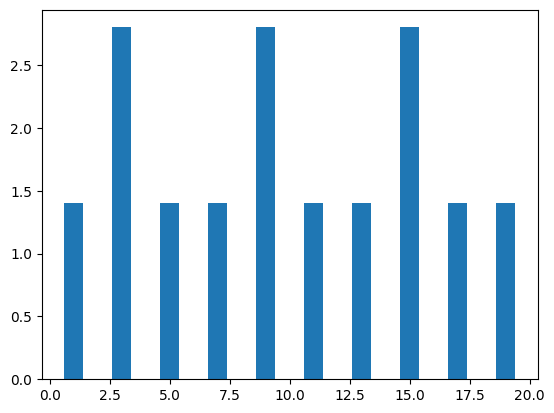

In [234]:
n = 3
## distribution factor
def get_Kd(n,slot,pole):
    m = slot/pole/3
    alpha = 180/m/3*np.pi/180
    Kd = np.sin(n*m*alpha/2)/(m*np.sin(n*alpha/2))
    return Kd
Kd = get_Kd(n,slot,pole)

## pitch factor
def get_Kp(n,slot,pole):
    P = slot/pole
    P = int(P)/P
    Kp = np.sin(n*P*90*np.pi/180)
    return Kp
Kw = []
for i in range(1,21,2):
    Kd = get_Kd(i,slot,pole)
    Kp = get_Kp(i,slot,pole)
    Kw.append(abs(Kd*Kp))
plt.bar(range(1,21,2),Kw)
plt.show()



## 6.7 inductance revisited

In [235]:
Sk = [1,1,1,0,-1,-1,-1,1,2,2,1,-1,-1,-1,0]
def sign(x):
    if x>0:
        return 1
    elif x<0:
        return -1
    else:
        return 0
def get_Lg(Sk):
    sigma = 0
    sum_Sk = sum(Sk)
    for i in range(len(Sk)):
        sigma += sign(Sk[i])*(Sk[i]-sum_Sk/len(Sk))
    return sigma
Lg = get_Lg(Sk)
Lg

14.8

In [236]:
## for phase A
#phase_a
df_A = df[df['phase_a']==1]
df_A = df_A[['slot_in','slot_out','phase_a']]
Sk = np.zeros(slot)
for i in range(len(df_A)):
    from_ = int(df_A.iloc[i]['slot_in'])
    to_ = int(df_A.iloc[i]['slot_out'])
    print('from',from_)
    print('to',to_)
    if from_ > to_:
        Sk[to_-1:from_] -=1
    elif from_ < to_:
        Sk[from_-1:to_] +=1
    print(Sk)


from 1
to 2
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
from 3
to 2
[ 1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
from 3
to 4
[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
from 14
to 15
[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
from 1
to 15
[2. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2.]
